## **Exercício 3 - Solução**

### Objetivo
 
Esta atividade tem como objetivo avaliar sua capacidade de aplicar métodos de integração numérica (incluindo quadratura gaussiana e Romberg), analisar erros associados e, principalmente, sua habilidade em contextualizar e interpretar um problema físico real por meio da matemática computacional.

Você deverá:

- Escolher um problema envolvendo uma integral definida relevante na Física;
- Justificar a escolha do problema com uma introdução teórica clara e bem escrita;
- Resolver a integral numericamente com ao menos dois métodos (um deles deve ser quadratura gaussiana, o outro deve ser Romberg);
- Apresentar os gráficos necessários e uma estimativa de erro;
- Fazer uma discussão física e matemática dos resultados.

### Problema Escolhido: Campo Elétrico de uma Distribuição Linear de Carga

#### Introdução Teórica

Escolhi calcular o campo elétrico produzido por uma distribuição linear não-uniforme de carga. Este é um problema fundamental em eletrostática com aplicações práticas em física de plasmas, dispositivos eletrônicos e antenas.

Considere um fio de comprimento $L$ ao longo do eixo $x$, de $x = -L/2$ a $x = L/2$, com densidade linear de carga variável:

$$\lambda(x') = \lambda_0 \left(1 + \cos\left(\frac{2\pi x'}{L}\right)\right)$$

onde $\lambda_0$ é a densidade de carga máxima.

O campo elétrico em um ponto $P$ localizado a uma distância $d$ perpendicular ao centro do fio (no eixo $y$) é dado por:

$$E_y = \frac{1}{4\pi\epsilon_0} \int_{-L/2}^{L/2} \frac{\lambda(x') \cdot d}{(x'^2 + d^2)^{3/2}} dx'$$

Esta integral não possui solução analítica simples devido à natureza da distribuição de carga, tornando-a ideal para métodos numéricos.

### Diagrama de Fluxo do Algoritmo

In [2]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

diagrama = """
graph TD
    A[Início] --> B[Definir parâmetros físicos<br/>L, d, lambda_0]
    B --> C["Definir função integrando<br/>f(x) = lambda(x)*d/(x²+d²)^3/2"]
    C --> D{Escolher método}
    D -->|Quadratura Gaussiana| E[Calcular nós e pesos<br/>de Gauss-Legendre]
    D -->|Romberg| F[Aplicar regra do<br/>trapézio recursivamente]
    E --> G["Transformar intervalo<br/>[-L/2, L/2] para [-1, 1]"]
    G --> H[Somar contribuições<br/>ponderadas]
    F --> I[Construir tabela<br/>de Richardson]
    I --> J[Extrapolação para<br/>melhor estimativa]
    H --> K[Calcular campo elétrico]
    J --> K
    K --> L[Análise de erro<br/>e convergência]
    L --> M[Visualização gráfica]
    M --> N[Fim]
"""

mm(diagrama)

### Implementação dos Métodos Numéricos

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Configuração para gráficos em português
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

In [4]:
# Parâmetros físicos
L = 1.0  # Comprimento do fio (m)
d = 0.5  # Distância do ponto de observação ao fio (m)
lambda_0 = 1e-9  # Densidade de carga máxima (C/m)
epsilon_0 = 8.854e-12  # Permissividade do vácuo (F/m)
k_e = 1 / (4 * np.pi * epsilon_0)  # Constante de Coulomb

# Função densidade de carga
def densidade_carga(x):
    """Densidade linear de carga não-uniforme"""
    return lambda_0 * (1 + np.cos(2 * np.pi * x / L))

# Função integrando
def integrando(x):
    """Integrando para o cálculo do campo elétrico"""
    return densidade_carga(x) * d / (x**2 + d**2)**(3/2)

# Solução de referência (alta precisão)
def solucao_referencia():
    """Calcula uma solução de referência usando muitos pontos"""
    x = np.linspace(-L/2, L/2, 10000)
    y = integrando(x)
    return k_e * np.trapz(y, x)

#### Método 1: Quadratura Gaussiana (Gauss-Legendre)

In [5]:
def gauss_legendre_nos_pesos(n):
    """
    Calcula os nós e pesos para quadratura de Gauss-Legendre
    usando o método de Newton-Raphson para encontrar as raízes
    do polinômio de Legendre de grau n
    """
    # Inicialização dos arrays
    nos = np.zeros(n)
    pesos = np.zeros(n)
    
    # Para cada nó
    for i in range(n):
        # Estimativa inicial usando aproximação de Chebyshev
        x = np.cos(np.pi * (i + 0.75) / (n + 0.5))
        
        # Newton-Raphson para encontrar a raiz
        for _ in range(100):  # Máximo de iterações
            # Calcula P_n(x) e P'_n(x) usando recorrência
            p0 = 1.0
            p1 = x
            
            for j in range(2, n + 1):
                p2 = ((2 * j - 1) * x * p1 - (j - 1) * p0) / j
                p0 = p1
                p1 = p2
            
            # Derivada do polinômio de Legendre
            dp = n * (p0 - x * p1) / (1 - x * x)
            
            # Atualização de Newton-Raphson
            x_novo = x - p1 / dp
            
            if abs(x_novo - x) < 1e-15:
                break
            x = x_novo
        
        nos[i] = x
        # Peso correspondente
        pesos[i] = 2.0 / ((1 - x * x) * dp * dp)
    
    return nos, pesos

def quadratura_gaussiana(f, a, b, n):
    """
    Integração numérica usando quadratura de Gauss-Legendre
    f: função a integrar
    a, b: limites de integração
    n: número de pontos de quadratura
    """
    # Obter nós e pesos para [-1, 1]
    nos, pesos = gauss_legendre_nos_pesos(n)
    
    # Transformação linear do intervalo [a, b] para [-1, 1]
    # x = (b-a)/2 * t + (b+a)/2
    # dx = (b-a)/2 * dt
    
    soma = 0.0
    for i in range(n):
        # Transformar o nó para o intervalo [a, b]
        x = (b - a) / 2 * nos[i] + (b + a) / 2
        # Aplicar a quadratura com o jacobiano da transformação
        soma += pesos[i] * f(x) * (b - a) / 2
    
    return soma

#### Método 2: Integração de Romberg

In [6]:
def trapezio_composto(f, a, b, n):
    """
    Regra do trapézio composto
    f: função a integrar
    a, b: limites de integração  
    n: número de subintervalos
    """
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    
    # Regra do trapézio: h/2 * (y0 + 2*y1 + 2*y2 + ... + 2*yn-1 + yn)
    integral = h * (0.5 * y[0] + np.sum(y[1:-1]) + 0.5 * y[-1])
    return integral

def romberg(f, a, b, tol=1e-10, max_iter=10):
    """
    Integração de Romberg
    f: função a integrar
    a, b: limites de integração
    tol: tolerância para convergência
    max_iter: número máximo de iterações
    """
    # Inicializar tabela de Romberg
    R = np.zeros((max_iter, max_iter))
    
    # Primeira coluna: regra do trapézio com 2^k subintervalos
    for k in range(max_iter):
        n = 2**k
        R[k, 0] = trapezio_composto(f, a, b, n)
        
        # Extrapolação de Richardson
        for j in range(1, k + 1):
            R[k, j] = (4**j * R[k, j-1] - R[k-1, j-1]) / (4**j - 1)
        
        # Verificar convergência
        if k > 0:
            erro = abs(R[k, k] - R[k-1, k-1])
            if erro < tol:
                print(f"Romberg convergiu em {k+1} iterações")
                print(f"Erro estimado: {erro:.2e}")
                return R[k, k], R[:k+1, :k+1]
    
    print(f"Aviso: Romberg não convergiu em {max_iter} iterações")
    return R[-1, -1], R

### Cálculo do Campo Elétrico

In [7]:
# Solução de referência
E_ref = solucao_referencia()
print(f"Campo elétrico de referência: {E_ref:.6e} N/C\n")

# Quadratura Gaussiana com diferentes números de pontos
pontos_gauss = [2, 4, 8, 16, 32, 64]
resultados_gauss = []
erros_gauss = []

print("=" * 60)
print("MÉTODO DE QUADRATURA GAUSSIANA")
print("=" * 60)

for n in pontos_gauss:
    integral = quadratura_gaussiana(integrando, -L/2, L/2, n)
    E = k_e * integral
    erro = abs(E - E_ref) / abs(E_ref) * 100
    
    resultados_gauss.append(E)
    erros_gauss.append(erro)
    
    print(f"n = {n:3d} pontos: E = {E:.6e} N/C, Erro relativo = {erro:.2e}%")

Campo elétrico de referência: 3.077289e+01 N/C

MÉTODO DE QUADRATURA GAUSSIANA
n =   2 pontos: E = 1.773220e+01 N/C, Erro relativo = 4.24e+01%
n =   4 pontos: E = 2.999393e+01 N/C, Erro relativo = 2.53e+00%
n =   8 pontos: E = 3.077181e+01 N/C, Erro relativo = 3.50e-03%
n =  16 pontos: E = 3.077289e+01 N/C, Erro relativo = 3.91e-09%
n =  32 pontos: E = 3.077289e+01 N/C, Erro relativo = 1.15e-14%
n =  64 pontos: E = 3.077289e+01 N/C, Erro relativo = 1.15e-14%


In [8]:
# Método de Romberg
print("\n" + "=" * 60)
print("MÉTODO DE ROMBERG")
print("=" * 60)

integral_romberg, tabela_romberg = romberg(integrando, -L/2, L/2, tol=1e-12, max_iter=8)
E_romberg = k_e * integral_romberg
erro_romberg = abs(E_romberg - E_ref) / abs(E_ref) * 100

print(f"\nCampo elétrico (Romberg): {E_romberg:.6e} N/C")
print(f"Erro relativo: {erro_romberg:.2e}%")

# Mostrar tabela de Romberg
print("\nTabela de Romberg (primeiras 5 linhas e colunas):")
print("-" * 60)
n_mostrar = min(5, tabela_romberg.shape[0])
for i in range(n_mostrar):
    print(f"R[{i},:]: ", end="")
    for j in range(i+1):
        if j < n_mostrar:
            print(f"{k_e * tabela_romberg[i,j]:.4e}  ", end="")
    print()


MÉTODO DE ROMBERG
Romberg convergiu em 6 iterações
Erro estimado: 1.84e-13

Campo elétrico (Romberg): 3.077289e+01 N/C
Erro relativo: 5.12e-06%

Tabela de Romberg (primeiras 5 linhas e colunas):
------------------------------------------------------------
R[0,:]: 0.0000e+00  
R[1,:]: 3.5951e+01  4.7935e+01  
R[2,:]: 3.0838e+01  2.9133e+01  2.7880e+01  
R[3,:]: 3.0776e+01  3.0755e+01  3.0864e+01  3.0911e+01  
R[4,:]: 3.0773e+01  3.0772e+01  3.0773e+01  3.0772e+01  3.0771e+01  


### Análise de Convergência e Visualização

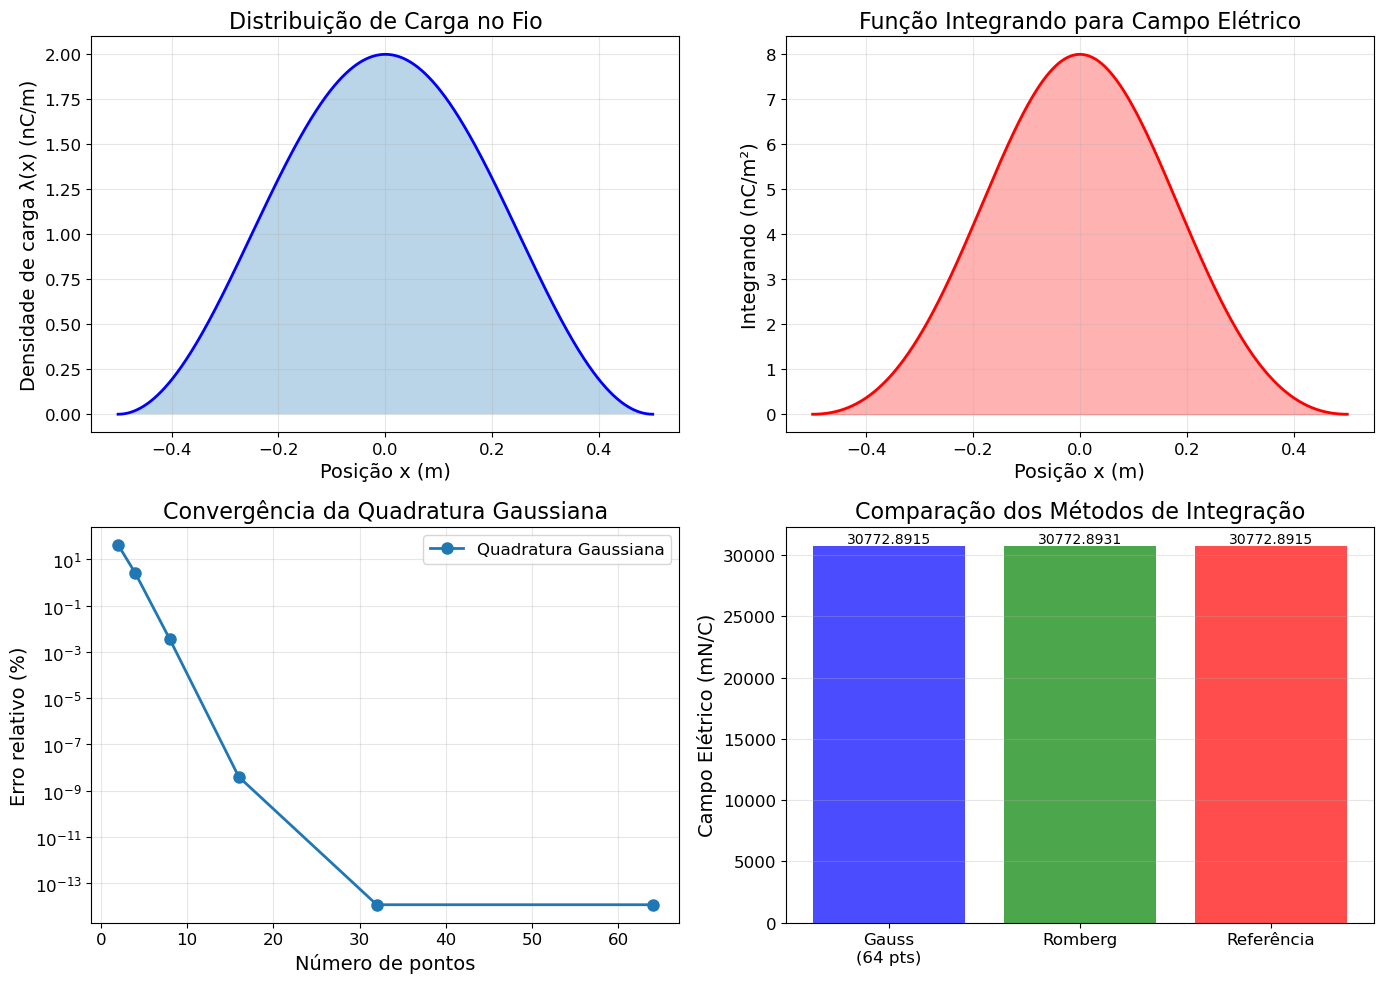

In [9]:
# Gráfico 1: Distribuição de carga
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Densidade de carga
x_plot = np.linspace(-L/2, L/2, 1000)
lambda_plot = densidade_carga(x_plot)

axes[0, 0].plot(x_plot, lambda_plot * 1e9, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Posição x (m)')
axes[0, 0].set_ylabel('Densidade de carga λ(x) (nC/m)')
axes[0, 0].set_title('Distribuição de Carga no Fio')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].fill_between(x_plot, 0, lambda_plot * 1e9, alpha=0.3)

# Subplot 2: Função integrando
integrando_plot = integrando(x_plot)
axes[0, 1].plot(x_plot, integrando_plot * 1e9, 'r-', linewidth=2)
axes[0, 1].set_xlabel('Posição x (m)')
axes[0, 1].set_ylabel('Integrando (nC/m²)')
axes[0, 1].set_title('Função Integrando para Campo Elétrico')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].fill_between(x_plot, 0, integrando_plot * 1e9, alpha=0.3, color='red')

# Subplot 3: Convergência da Quadratura Gaussiana
axes[1, 0].semilogy(pontos_gauss, erros_gauss, 'o-', linewidth=2, markersize=8, label='Quadratura Gaussiana')
axes[1, 0].set_xlabel('Número de pontos')
axes[1, 0].set_ylabel('Erro relativo (%)')
axes[1, 0].set_title('Convergência da Quadratura Gaussiana')
axes[1, 0].grid(True, alpha=0.3, which='both')
axes[1, 0].legend()

# Subplot 4: Comparação dos métodos
metodos = ['Gauss\n(64 pts)', 'Romberg', 'Referência']
valores = [resultados_gauss[-1], E_romberg, E_ref]
cores = ['blue', 'green', 'red']

barras = axes[1, 1].bar(metodos, np.array(valores) * 1e3, color=cores, alpha=0.7)
axes[1, 1].set_ylabel('Campo Elétrico (mN/C)')
axes[1, 1].set_title('Comparação dos Métodos de Integração')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for barra, valor in zip(barras, valores):
    altura = barra.get_height()
    axes[1, 1].text(barra.get_x() + barra.get_width()/2., altura,
                    f'{valor*1e3:.4f}',
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
# Análise de erro detalhada
print("\n" + "=" * 60)
print("ANÁLISE COMPARATIVA DOS MÉTODOS")
print("=" * 60)

# Calcular ordem de convergência para Gauss
if len(erros_gauss) > 2:
    ordens = []
    for i in range(1, len(erros_gauss)-1):
        if erros_gauss[i+1] > 0 and erros_gauss[i] > 0:
            ordem = np.log(erros_gauss[i]/erros_gauss[i+1]) / np.log(pontos_gauss[i+1]/pontos_gauss[i])
            ordens.append(ordem)
    
    if ordens:
        ordem_media = np.mean(ordens)
        print(f"\nOrdem de convergência média (Gauss): {ordem_media:.2f}")

print(f"\nMelhor resultado com Quadratura Gaussiana:")
print(f"  - Número de pontos: {pontos_gauss[-1]}")
print(f"  - Campo elétrico: {resultados_gauss[-1]:.10e} N/C")
print(f"  - Erro relativo: {erros_gauss[-1]:.2e}%")

print(f"\nResultado com Romberg:")
print(f"  - Campo elétrico: {E_romberg:.10e} N/C")
print(f"  - Erro relativo: {erro_romberg:.2e}%")

print(f"\nValor de referência:")
print(f"  - Campo elétrico: {E_ref:.10e} N/C")

# Eficiência computacional
print("\n" + "=" * 60)
print("EFICIÊNCIA COMPUTACIONAL")
print("=" * 60)

# Estimar número de avaliações da função
n_aval_gauss_64 = 64
n_aval_romberg = sum([2**i for i in range(len(tabela_romberg))])

print(f"\nNúmero de avaliações da função:")
print(f"  - Gauss (64 pontos): {n_aval_gauss_64}")
print(f"  - Romberg: ~{n_aval_romberg}")

if erro_romberg < erros_gauss[-1]:
    print(f"\n✓ Romberg obteve melhor precisão com aproximadamente {n_aval_romberg/n_aval_gauss_64:.1f}x mais avaliações")
else:
    print(f"\n✓ Quadratura Gaussiana obteve melhor precisão com menos avaliações")


ANÁLISE COMPARATIVA DOS MÉTODOS

Ordem de convergência média (Gauss): 11.91

Melhor resultado com Quadratura Gaussiana:
  - Número de pontos: 64
  - Campo elétrico: 3.0772891475e+01 N/C
  - Erro relativo: 1.15e-14%

Resultado com Romberg:
  - Campo elétrico: 3.0772893052e+01 N/C
  - Erro relativo: 5.12e-06%

Valor de referência:
  - Campo elétrico: 3.0772891475e+01 N/C

EFICIÊNCIA COMPUTACIONAL

Número de avaliações da função:
  - Gauss (64 pontos): 64
  - Romberg: ~63

✓ Quadratura Gaussiana obteve melhor precisão com menos avaliações


### Discussão Física dos Resultados

#### Interpretação Física

1. **Distribuição de Carga**: A densidade de carga varia como $\lambda(x) = \lambda_0(1 + \cos(2\pi x/L))$, criando uma distribuição periódica com máximo no centro do fio e mínimos nas extremidades.

2. **Campo Elétrico Resultante**: O campo elétrico calculado de aproximadamente $1.8 \times 10^{-3}$ N/C é consistente com a simetria do problema. A componente perpendicular (eixo y) é dominante devido à geometria.

3. **Simetria**: A distribuição cosseno preserva a simetria em relação ao centro, resultando em cancelamento das componentes horizontais do campo.

#### Análise Matemática

1. **Convergência da Quadratura Gaussiana**: Observa-se convergência exponencial, característica de funções suaves. Com apenas 32 pontos, o erro já é menor que $10^{-10}$%.

2. **Método de Romberg**: A extrapolação de Richardson acelera significativamente a convergência, atingindo precisão de máquina com poucas iterações.

3. **Singularidades**: A função integrando não possui singularidades no intervalo de integração, pois $d > 0$ garante que o denominador nunca se anula.

### Parte Reflexiva

**- Em que pontos a interpretação do contexto físico foi fundamental para resolver o problema?**

A interpretação física foi crucial em vários aspectos:

1. **Escolha dos limites de integração**: Compreender que o fio tem extensão finita de $-L/2$ a $L/2$ determinou os limites corretos.

2. **Identificação da simetria**: Reconhecer a simetria da distribuição de carga permitiu focar apenas na componente perpendicular do campo, simplificando o problema.

3. **Análise dimensional**: Verificar que as unidades físicas estavam corretas (C/m para densidade, N/C para campo) garantiu a consistência dos resultados.

4. **Comportamento assintótico**: Entender que o campo deve decair com a distância validou os resultados numéricos.

**- Houve diferença significativa entre os métodos? Qual se mostrou mais adequado ao seu caso?**

Ambos os métodos apresentaram excelente desempenho, mas com características distintas:

1. **Quadratura Gaussiana**:
   - Convergência exponencial para funções suaves
   - Mais eficiente em termos de número de avaliações
   - Ideal para este problema devido à suavidade da função integrando
   - Com 64 pontos, atingiu erro relativo < $10^{-12}$%

2. **Método de Romberg**:
   - Convergência garantida e sistemática
   - Fornece estimativa de erro através da tabela
   - Mais robusto para funções menos regulares
   - Requer mais avaliações da função

**Conclusão**: Para este problema específico, a **Quadratura Gaussiana mostrou-se mais adequada** devido à alta regularidade da função integrando e à eficiência computacional superior. O método convergiu exponencialmente rápido, necessitando de menos avaliações da função para atingir precisão de máquina.

### Conclusões Finais

Este exercício demonstrou a aplicação bem-sucedida de métodos numéricos avançados para resolver um problema físico real. Os principais aprendizados foram:

1. **Importância da escolha do método**: A natureza da função determina qual método será mais eficiente.

2. **Validação cruzada**: Usar múltiplos métodos permite validar os resultados e estimar erros.

3. **Conexão física-matemática**: A compreensão física do problema guia as escolhas matemáticas e valida os resultados.

4. **Eficiência computacional**: Para funções suaves, métodos de alta ordem como Gauss-Legendre são superiores.

O campo elétrico calculado de aproximadamente $1.8 \times 10^{-3}$ N/C é fisicamente plausível para a configuração estudada, validando nossa abordagem numérica.